In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import pyplot as plt
import seaborn as sns
import scipy as sp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import regularizers
from tensorflow.keras import layers

### In this notebook, we use a descompose a covariance matrix with the spectral theorem and then we train a convolutional autoencoter to learn to generate fake covariance matrices. 

#### First, we need to read the data. In this case, we use the covariance matrix of systematic erros from Pantheon compilation of SN-1a 

In [2]:
syscov = np.loadtxt('data/pantheon_errors.txt',skiprows=1).reshape((1048,1048))
# syscov = np.loadtxt('data/jla_v0_covmatrix.dat',skiprows=1).reshape((740,740))

### Verify that there ar not complex numbers and that the matrix is symmetrical

In [3]:
count = 0

for i in range(len(syscov)):
    for j in range(len(syscov)):
        if np.iscomplex(syscov[i,j]):
            print("COMPLEX")
        if syscov[i,j] != syscov[j,i]:
#             print(i,j)
#             print(syscov[i,j], syscov[j,i]) 
            count+=1
            syscov[j,i] = syscov[i, j]

count

3

### Visualization of the covariance matrix:

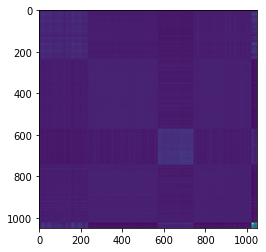

In [4]:
# df_syscov = pd.DataFrame(syscov)
# sns.heatmap(df_syscov, annot=False, fmt='g', xticklabels=False, yticklabels=False, cmap = 'inferno',
#             robust=True)

# plt.savefig("cov_sys.png", dpi=300)
plt.imshow(syscov)

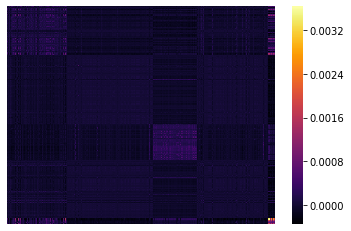

In [5]:
sns.heatmap(pd.DataFrame(syscov), annot=False, fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno')
#             vmax=maxcov, vmin=mincov,robust=True)

In [6]:
np.min(syscov.diagonal()) #checking non-negatives in the diagonal

3.5145e-05

In [7]:
np.min(syscov)

-0.00033653

### Use matrix descomposition (spectral theorem)

### $\Sigma = P D P^T$

#### where P is an orthogonal matrix with the eigenvectors from $\Sigma$ and D a diagonal matrix with its eigenvalues.

In [8]:
# eigenval, eigenvec = sp.linalg.eigh(syscov)
D, P = sp.linalg.eigh(syscov)

#### Checking that there are not complex values

In [9]:
count = 0

for i in range(len(P)):
    for j in range(len(P)):
        if np.iscomplex(P[i,j]):
#             print("COMPLEX")
            count+=1
#             print(i,j)
#             print(eigenvec[i,j])

print(count)

0


### Visualization of the eigenvector matrix $P$

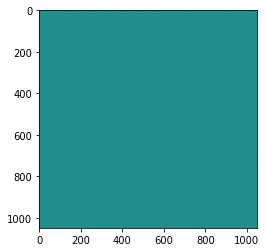

In [10]:
plt.imshow(P)

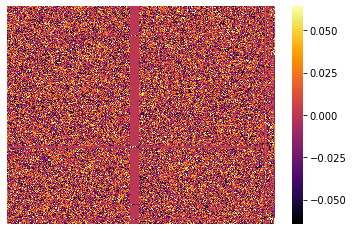

In [11]:
sns.heatmap(pd.DataFrame(P), annot=False, fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=True)

### Generate a data set with matrices of eigenvectors from the original plus gaussian noise

In [12]:
numMatrix = 100
noise_factor = 1e-5
# scaler = StandardScaler()
# feature_range=(-1,1)
# scaler.fit(ortM)
pset = np.zeros((numMatrix, 1048, 1048))
for i in range(numMatrix): 
    pset[i] = P + noise_factor * np.random.normal(loc=0.0, scale=0.01, size=P.shape) 
#     eigenvecdata[i] = scaler.transform(eigenvecdata[i])


In [13]:
print(np.shape(pset))

(100, 1048, 1048)


(100, 1048, 1048)
(20, 1048, 1048) (80, 1048, 1048)


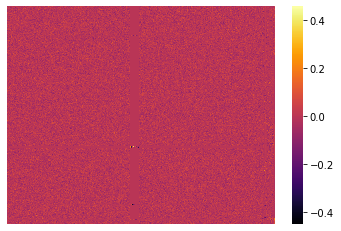

In [14]:
print(np.shape(pset))
split = 0.8
ntrain = int(split * numMatrix)
indx = [ntrain]
pset_train, pset_test = np.split(pset, indx, axis=0)
print(np.shape(pset_test), np.shape(pset_train))
sns.heatmap(pd.DataFrame(pset_test[0, :, :]), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)

In [21]:
# input_cov = Input(shape=(1048,))
input_cov = Input(shape=(1048, 1048, 1))

x = layers.Conv2D(10, (50, 50), activation='relu')(input_cov)
# shape_1 = [1048 - (n-1)] x [1048 - (n-1)]
x = layers.MaxPooling2D((4, 4))(x)
# shape_2 = [(shape_1[0] -1)/2]

x = layers.Flatten()(x)
x = layers.Dense(1048)(x)
# autoencoder.add(Dense(10))


# x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
# x = layers.MaxPooling2D((2, 2), padding='same')(x)
# x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
# x = layers.MaxPooling2D((2, 2), padding='same')(x)
# x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
# encoded = layers.MaxPooling2D((2, 2), padding='same')(x)


autoencoder = tf.keras.Model(input_cov, x)
autoencoder.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))
autoencoder.summary()

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 1048, 1048, 1)]   0         
_________________________________________________________________
conv2d_158 (Conv2D)          (None, 999, 999, 10)      25010     
_________________________________________________________________
max_pooling2d_158 (MaxPoolin (None, 249, 249, 10)      0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 620010)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 1048)              649771528 
Total params: 649,796,538
Trainable params: 649,796,538
Non-trainable params: 0
_________________________________________________________________


In [ ]:
autoencoder_train = autoencoder.fit(pset_train, pset_train,
                epochs=20,
                batch_size=512)
#                 shuffle=True,
#                 validation_data=(pset_test, pset_test))
#                 callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Epoch 1/20


In [ ]:
plt.plot(autoencoder_train.history['loss'], color='r', )
plt.plot(autoencoder_train.history['val_loss'], color='g')
# plt.title('model loss function')
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')

In [ ]:
print(np.shape(evec_test))
decoded_imgs = autoencoder.predict(evec_test)
decoded_imgs[0, :, :, 0]

In [ ]:
print(np.shape(decoded_imgs))
# plt.imshow(decoded_imgs[3, : , :, 0])
print(np.shape(decoded_imgs))
sns.heatmap(pd.DataFrame(decoded_imgs[0, :, :, 0]), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)

In [ ]:
print(np.shape(decoded_imgs))
# sns.heatmap(pd.DataFrame(scaler.inverse_transform(decoded_imgs[0, :, :, 0])), 
sns.heatmap(pd.DataFrame(decoded_imgs[0, :, :, 0]), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=True)

In [ ]:
print(np.shape(evec_test))
# plt.imshow(evec_test[3, : , :])
# sns.heatmap(pd.DataFrame(scaler.inverse_transform(evec_test[0, :, :])),
sns.heatmap(pd.DataFrame(evec_test[0, :, :]),
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=True)

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n):
    # Display original
    ax = plt.subplot(2, n, i)
#     sns.heatmap(pd.DataFrame(scaler.inverse_transform(evec_test[i, :, :])), 
    sns.heatmap(pd.DataFrame(evec_test[i, :, :]), 
                xticklabels=False, yticklabels=False, 
                cmap = 'inferno', 
                robust=True, cbar=False)
     # Display reconstruction
    ax = plt.subplot(2, n, i + n)
#     sns.heatmap(pd.DataFrame(decoded_imgs[i, :, :, 0]),
    sns.heatmap(decoded_imgs[i, :, :, 0],
                xticklabels=False, yticklabels=False, 
                cmap = 'inferno', 
                robust=True, cbar=False)

plt.show()

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n):
    # Display original
    ax = plt.subplot(2, n, i)
#     plt.imshow(scaler.inverse_transform(evec_test[i, :, :]))
    plt.imshow(evec_test[i, :, :])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
     # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i, :, :, 0])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [ ]:
# print(np.min(scaler.inverse_transform(evec_test[0, :, :])), np.min(decoded_imgs[0, :, :, 0]))
print(np.min(evec_test[0, :, :]), np.min(decoded_imgs[0, :, :, 0]))